## warehouse collision 해결하고 warehouse에 코드로 넣기

### deadend 해결을 heuristic map으로 구현한다면, navigate 설정을 조금 바꿔야 함 (어렵지 않음)

In [7]:
import os
import numpy as np
from crewai import Agent, Task, Crew
from environment import Environment
from openai import OpenAI
import copy
import configs
import pickle

os.environ["OPENAI_API_KEY"] = ""
client = OpenAI()

In [8]:
#negotiator를 구성하기 위한 union find 알고리즘

def find(parent, i):
    if parent[i] == i:
        return i
    else:
        return find(parent, parent[i])

def union(parent, rank, x, y):
    xroot = find(parent, x)
    yroot = find(parent, y)

    if xroot != yroot:
        if rank[xroot] < rank[yroot]:
            parent[xroot] = yroot
        elif rank[xroot] > rank[yroot]:
            parent[yroot] = xroot
        else:
            parent[yroot] = xroot
            rank[xroot] += 1

def merge_sets(lists):
    element_to_index = {}
    for i, subset in enumerate(lists):
        for element in subset:
            element_to_index[element] = i

    parent = [i for i in range(len(lists))]
    rank = [0] * len(lists)

    for subset in lists:
        first_element = subset[0]
        for element in subset[1:]:
            union(parent, rank, find(parent, element_to_index[first_element]), find(parent, element_to_index[element]))

    new_sets = {}
    for element in element_to_index:
        root = find(parent, element_to_index[element])
        if root not in new_sets:
            new_sets[root] = set()
        new_sets[root].add(element)

    return [list(s) for s in new_sets.values()]

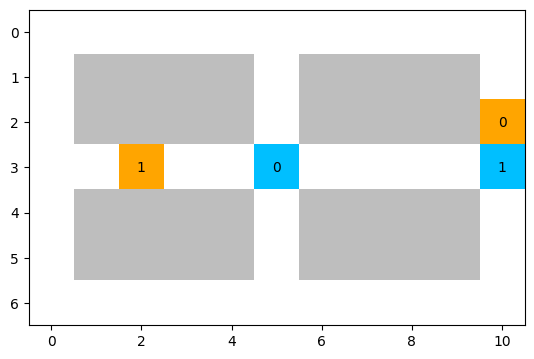

In [9]:
directiondict = {
    'Stay': 0, 'North': 1, 'South': 2, 'West': 3, 'East': 4, 'Stay.': 0, 'North.': 1, 'South.': 2, 'West.': 3, 'East.': 4 
}

# Toy example 만들기(환경, 처음 위치, 목적지)
toy = (np.array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0], [0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0], [0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]), np.array([[3, 5], [3, 10]]), np.array([[2, 10], [3, 2]]))
num_agents = len(toy[1])
map_width = len(toy[0][0]) - 1

env = Environment()
env.load(toy[0], toy[1], toy[2])
env.render()

In [10]:
class PathFindingAgents:
  def path_finder(self, agent_number):
    return Agent(
      role='Path finder',
      goal='Start at the start point and reach the end point without crashing into a wall.',
      backstory=f"""You are a veteran adventurer with a great sense of direction.
      You understand which direction you need to move to get from where you are to where you want to go.
      Your agent number is {agent_number}.
      """,
      verbose=True
    )
    
  def negotiator(self):
    return Agent(
      role='Negotiator',
      goal="""Determine whether the deadlocked agents would collide with each other if they took their original planned moves, and if so, stop all but the agent with the largest number.""",
      backstory="""You're a veteran overseer, and you've been called in to resolve the deadlock, as each agent is in the other's line of sight.
      """,
      verbose=True,
    )
	
class PathFindingTasks():
  def path_finding(self, agent, x, y, x_finish, y_finish, east, west, north, south, last_action):
    return Task(
      description=(
        f"""
        Your current coordinates are ({x},{y}) and your destination is ({x_finish},{y_finish}).
        East and west in the coordinates correspond to the x axis.
        South and north in the coordinates correspond to the y axis.
        You can only move east, west, south and north or stay.
        So, your answer will be {{East}}, {{West}}, {{South}}, {{North}}, or {{Stay}}.
        You can only make one move at a time.
        {east}
        {west}
        {south}
        {north}
        Which direction do you move next?
        {last_action}
        Answer in one word only: {{DIRECTION or ACTION}}
        """
      ),
      expected_output='Direction or action',
      agent=agent
    )
    
  def negotiate(self, agent):
    return Task(
      description=(
        f"""
        Determine whether the deadlocked agents would collide with each other if they took their original planned moves, and if so, stop all but the agent with the largest number.
        The planned moves of each agent represent the previous outcomes.
        """
      ),
      expected_output='Direction of the agents',
      agent=agent
    )
  
  def give_way(self, agent, east, west, north, south, direction):
    return Task(
      description=(
        f"""
        You MUST avoid collisions with prior path finder.
        You can only move east, west, south and north or stay.
        So, your answer will be {{East}}, {{West}}, {{South}}, {{North}}, or {{Stay}}.
        You can only make one move at a time.
        {east}
        {west}
        {south}
        {north}
        To the {direction} of you is prior path finder.
        Which direction do you move next?
        I highly recommend going to the 90-degree turn rather than the other side of the pathfinder, but you can ignore this instruction depending on your situation.
        Answer in one word only: {{DIRECTION or ACTION}}
        """
      ),
      expected_output='Direction or action',
      agent=agent
    )

agents = PathFindingAgents()
tasks = PathFindingTasks()

agents_set = [agents.path_finder(i) for i in range(num_agents)]
negotiator = agents.negotiator()

In [11]:
#에이전트들의 지난번 액션들
action_list = [[] for _ in range(num_agents)]

2024-06-18 14:45:15,734 - 20764 - __init__.py-__init__:518 - WARNING: Overriding of current TracerProvider is not allowed




> Entering new CrewAgentExecutor chain...


2024-06-18 14:45:20,409 - 20764 - __init__.py-__init__:518 - WARNING: Overriding of current TracerProvider is not allowed


Considering my current position at (5,7) and my destination at (10,8), the most logical move would be to head towards the x-axis value of my destination. Since 10 is greater than 5 and East corresponds to the increase in the x-axis, I should move East.

Final Answer: East

> Finished chain.


> Entering new CrewAgentExecutor chain...
Based on my current coordinates and the destination, it seems that I need to move westward on the x-axis to reach the goal. There's a path available in that direction, so it shouldn't be a problem.

Final Answer: West

> Finished chain.


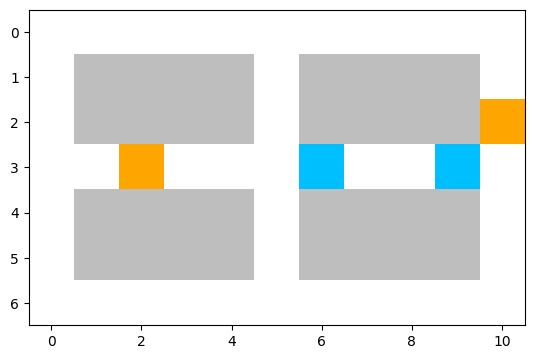

2024-06-18 14:45:23,660 - 20764 - __init__.py-__init__:518 - WARNING: Overriding of current TracerProvider is not allowed




> Entering new CrewAgentExecutor chain...


2024-06-18 14:45:26,879 - 20764 - __init__.py-__init__:518 - WARNING: Overriding of current TracerProvider is not allowed


Since my current coordinates are (6,7) and my destination is at (10,8), I need to move towards the east to increase my X coordinate. There is also a path available towards the east and there are walls blocking my way to the south and north. Therefore, the best direction for me to move is east.

Final Answer: East

> Finished chain.


> Entering new CrewAgentExecutor chain...
Considering my current position at (9,7), I need to move to the destination at (2,7). Considering the constraints, I can only move east or west as north and south are blocked by walls. Since my destination lies to the west of my current position, I should move west.

Final Answer: West

> Finished chain.


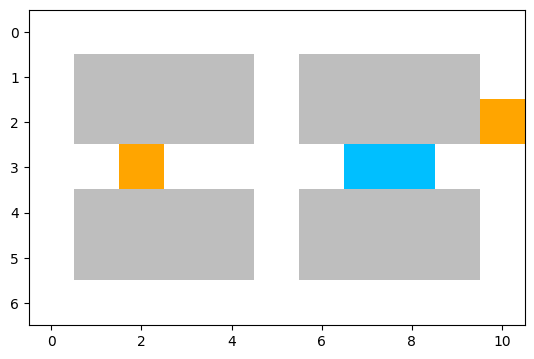

2024-06-18 14:45:31,222 - 20764 - __init__.py-__init__:518 - WARNING: Overriding of current TracerProvider is not allowed




> Entering new CrewAgentExecutor chain...


2024-06-18 14:45:33,660 - 20764 - __init__.py-__init__:518 - WARNING: Overriding of current TracerProvider is not allowed


Considering my current position and my destination, I need to move towards the east since my destination is towards the east and there's a path available in that direction.

Final Answer: East

> Finished chain.


> Entering new CrewAgentExecutor chain...


2024-06-18 14:45:37,531 - 20764 - __init__.py-__init__:518 - WARNING: Overriding of current TracerProvider is not allowed


Based on my current position (8,7) and the destination (2,7), it is clear that I need to move towards the west. However, I also need to consider the walls and paths around me. Given that my south and north are blocked by a wall, and I just came from the east, the only logical move would be to head west. 

Final Answer: West

> Finished chain.


> Entering new CrewAgentExecutor chain...
Based on the task's details, I am blocked from moving south and north by walls. To my east is a prior path finder, which I must avoid. Therefore, the only logical option left is to move west.

Final Answer: West.

> Finished chain.


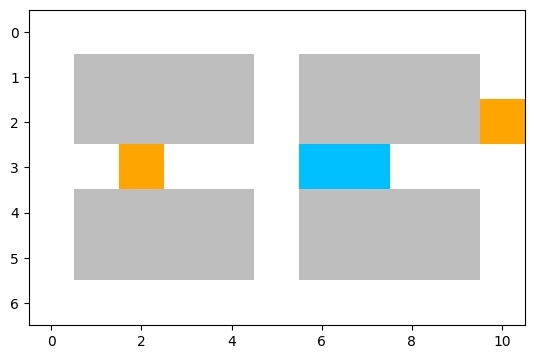

2024-06-18 14:45:41,660 - 20764 - __init__.py-__init__:518 - WARNING: Overriding of current TracerProvider is not allowed




> Entering new CrewAgentExecutor chain...


2024-06-18 14:45:44,388 - 20764 - __init__.py-__init__:518 - WARNING: Overriding of current TracerProvider is not allowed


Considering my current position (6,7) and my destination (10,8), I need to move towards the east to get closer to my destination. Also, there is a path available in the east direction and the other directions are blocked by walls.

Final Answer: East

> Finished chain.


> Entering new CrewAgentExecutor chain...


2024-06-18 14:45:48,208 - 20764 - __init__.py-__init__:518 - WARNING: Overriding of current TracerProvider is not allowed


Based on my current coordinates (7,7), I need to get to (2,7). This means I need to move along the x-axis in a negative direction, which is west. Since there is a path to the west and I came from the east, moving west would be the logical choice. 

Final Answer: West

> Finished chain.


> Entering new CrewAgentExecutor chain...
Considering all the available paths and obstacles, since the east is blocked by a prior path finder and the south and north are blocked by walls, the only viable option is to move west. 

Final Answer: West

> Finished chain.


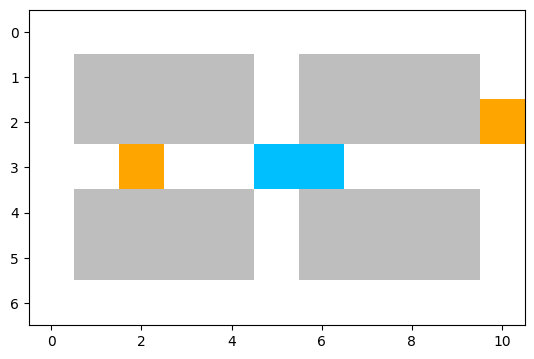

2024-06-18 14:45:51,473 - 20764 - __init__.py-__init__:518 - WARNING: Overriding of current TracerProvider is not allowed




> Entering new CrewAgentExecutor chain...


2024-06-18 14:45:53,723 - 20764 - __init__.py-__init__:518 - WARNING: Overriding of current TracerProvider is not allowed


Considering my current location (5,7) and my destination (10,8), I need to move towards the east to increase my x-coordinate to reach 10.

Final Answer: East

> Finished chain.


> Entering new CrewAgentExecutor chain...


2024-06-18 14:45:58,284 - 20764 - __init__.py-__init__:518 - WARNING: Overriding of current TracerProvider is not allowed


Since my current position is (6,7) and my target destination is (2,7), I need to move along the x-axis towards the west. Given the information provided, my path to the west is clear, while my path to the east, north, and south are blocked. Therefore, the best move for me would be to move west.

Final Answer: West

> Finished chain.


> Entering new CrewAgentExecutor chain...
Considering the situation, it seems that moving east would lead to a collision with the prior pathfinder. Therefore, it is not a viable option. However, I can move west, south, or north without any issues. Taking into account the recommendation, it would be best to take a 90-degree turn. So, moving north or south would be the best options. 

Final Answer: South

> Finished chain.


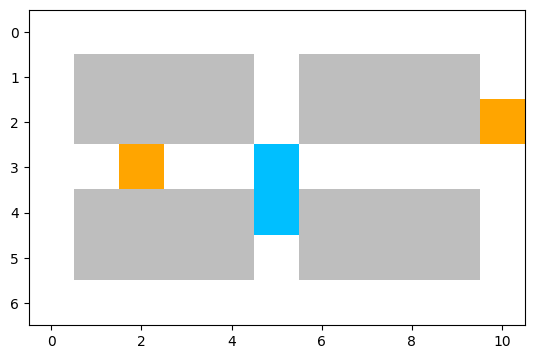

2024-06-18 14:46:02,041 - 20764 - __init__.py-__init__:518 - WARNING: Overriding of current TracerProvider is not allowed




> Entering new CrewAgentExecutor chain...


2024-06-18 14:46:05,177 - 20764 - __init__.py-__init__:518 - WARNING: Overriding of current TracerProvider is not allowed


Given my current position and the location of my destination, the best direction for me to move next would be north. However, considering that my east and west are blocked by walls, my only options are to move either south or north. My destination lies in the north, therefore, north is the most sensible choice.

Final Answer: North

> Finished chain.


> Entering new CrewAgentExecutor chain...
Considering my current coordinates are (5,7) and I need to reach (2,7), it is clear that I have to move towards the west to decrease my x-coordinate while the y-coordinate remains the same. As there are paths available in all directions and I came from the east, the best direction to move next is west.

Final Answer: West

> Finished chain.


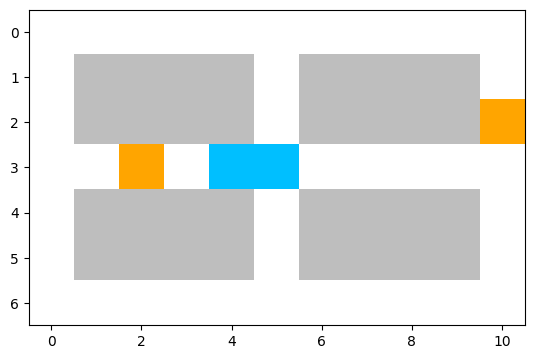

2024-06-18 14:46:09,414 - 20764 - __init__.py-__init__:518 - WARNING: Overriding of current TracerProvider is not allowed




> Entering new CrewAgentExecutor chain...


2024-06-18 14:46:13,810 - 20764 - __init__.py-__init__:518 - WARNING: Overriding of current TracerProvider is not allowed


Given my current position, the destination is to the East and slightly North of my current location. Since I can only make one move at a time and the destination is more to the East than it is to the North, the most logical move would be to head East as long as there is a path. 

Final Answer: East

> Finished chain.


> Entering new CrewAgentExecutor chain...
Considering my current position (4,7), the destination is at (2,7). This means I need to move towards the west. As the task states that there is a path to my west, I can safely move in that direction. My previous direction, east, is irrelevant as I need to move in the opposite direction to reach my destination.

Final Answer: West

> Finished chain.


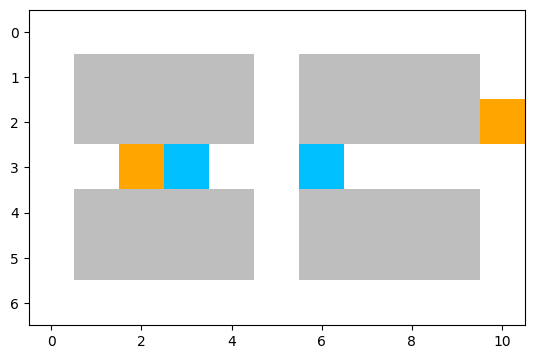

2024-06-18 14:46:18,845 - 20764 - __init__.py-__init__:518 - WARNING: Overriding of current TracerProvider is not allowed




> Entering new CrewAgentExecutor chain...


2024-06-18 14:46:21,809 - 20764 - __init__.py-__init__:518 - WARNING: Overriding of current TracerProvider is not allowed


Given my current position and the destination, I need to move East to get closer to the target coordinates. However, considering I just came from the West and there are walls to the North and South, the best option would be to move East.

Final Answer: East

> Finished chain.


> Entering new CrewAgentExecutor chain...
Considering my current location and destination, I must move in the direction which brings me closer to the destination. Given that I cannot move south or north due to the walls, and moving east would increase the x-coordinate which is not desired as my destination has a lesser x-coordinate than my current location, the only viable option left is to move west. This will decrease the x-coordinate by 1 and bring me to (2,7) which is exactly where I want to go.

Final Answer: West

> Finished chain.


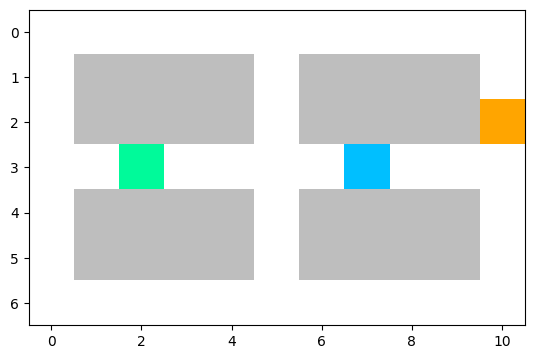

2024-06-18 14:46:26,718 - 20764 - __init__.py-__init__:518 - WARNING: Overriding of current TracerProvider is not allowed




> Entering new CrewAgentExecutor chain...


2024-06-18 14:46:30,580 - 20764 - __init__.py-__init__:518 - WARNING: Overriding of current TracerProvider is not allowed


Given my current location at (7,7) and destination at (10,8), and considering the available paths to the east and west with walls to the south and north, I need to move towards the destination. Since I came from the west, I need to move east to avoid backtracking. 

Final Answer: East

> Finished chain.


> Entering new CrewAgentExecutor chain...
Since I'm already at the destination point (2,7), there is no need to move.

Final Answer: Stay

> Finished chain.


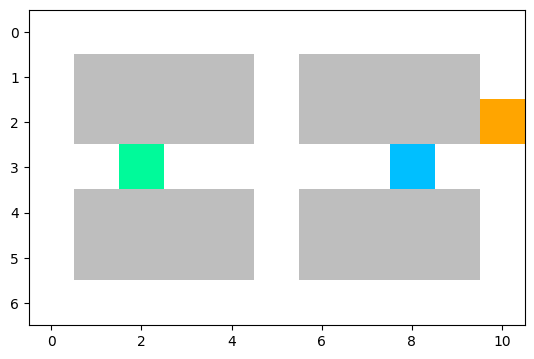

2024-06-18 14:46:32,961 - 20764 - __init__.py-__init__:518 - WARNING: Overriding of current TracerProvider is not allowed




> Entering new CrewAgentExecutor chain...


2024-06-18 14:46:36,750 - 20764 - __init__.py-__init__:518 - WARNING: Overriding of current TracerProvider is not allowed


Looking at the current coordinates, I am at (8,7) and my destination is (10,8). The destination is to the east of the current location. Since east is not blocked, I should move east to get closer to the destination.

Final Answer: East

> Finished chain.


> Entering new CrewAgentExecutor chain...
Given my current location and my destination, I don't need to move at all. I'm already at my target coordinates.

Final Answer: Stay.

> Finished chain.


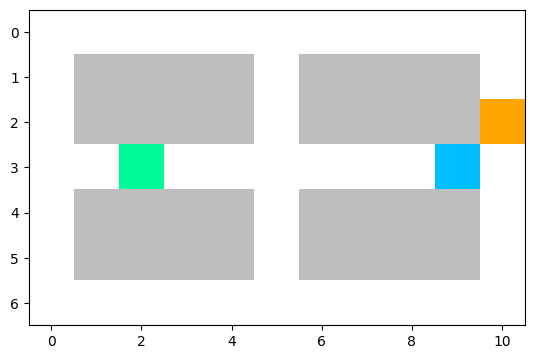

2024-06-18 14:46:40,769 - 20764 - __init__.py-__init__:518 - WARNING: Overriding of current TracerProvider is not allowed




> Entering new CrewAgentExecutor chain...


2024-06-18 14:46:42,886 - 20764 - __init__.py-__init__:518 - WARNING: Overriding of current TracerProvider is not allowed


Given my current coordinates, the destination coordinates, and the available paths, it seems clear that moving East will get me closer to the destination. 

Final Answer: East.

> Finished chain.


> Entering new CrewAgentExecutor chain...
Since I am already at my destination (2,7), there is no need for me to move. The best action to take is to stay put.

Final Answer: Stay

> Finished chain.


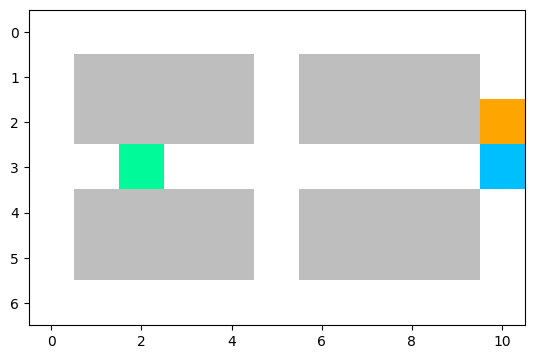

2024-06-18 14:46:45,828 - 20764 - __init__.py-__init__:518 - WARNING: Overriding of current TracerProvider is not allowed




> Entering new CrewAgentExecutor chain...


2024-06-18 14:46:48,447 - 20764 - __init__.py-__init__:518 - WARNING: Overriding of current TracerProvider is not allowed


Based on my current location and the destination, I need to move along the Y-axis. Since the destination is (10,8) which is greater than my current position (10,7), I should move in the North direction. 

Final Answer: North

> Finished chain.


> Entering new CrewAgentExecutor chain...
Since my current coordinates (2,7) are the same as my destination (2,7), it means I have already reached my goal. Therefore, my next move should be to stay.

Final Answer: Stay.

> Finished chain.


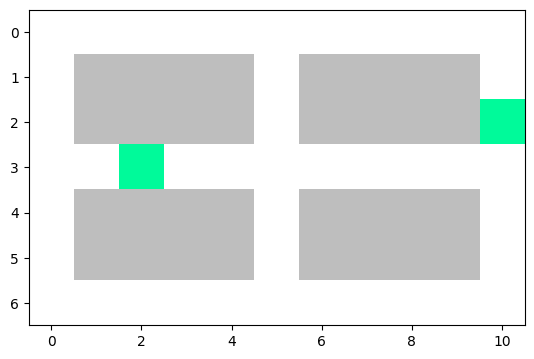

2024-06-18 14:46:51,728 - 20764 - __init__.py-__init__:518 - WARNING: Overriding of current TracerProvider is not allowed




> Entering new CrewAgentExecutor chain...


2024-06-18 14:46:53,714 - 20764 - __init__.py-__init__:518 - WARNING: Overriding of current TracerProvider is not allowed


Since my current coordinates are the same as my destination coordinates, I am already at the desired location. Therefore, I don't need to move in any direction.

Final Answer: Stay

> Finished chain.


> Entering new CrewAgentExecutor chain...
Since my current location is the same as my destination, there is no need for me to move. My action should therefore be to stay.

Final Answer: Stay.

> Finished chain.


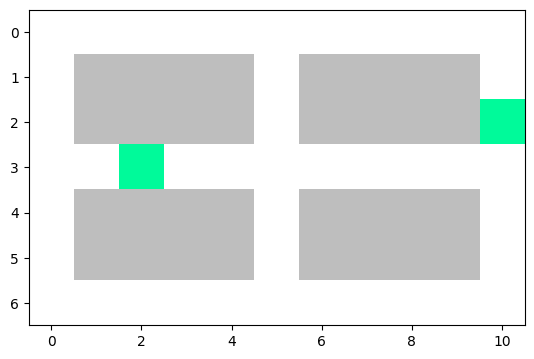

2024-06-18 14:46:56,045 - 20764 - __init__.py-__init__:518 - WARNING: Overriding of current TracerProvider is not allowed




> Entering new CrewAgentExecutor chain...


2024-06-18 14:46:58,089 - 20764 - __init__.py-__init__:518 - WARNING: Overriding of current TracerProvider is not allowed


I am already at the destination coordinates (10,8), so I don't need to move in any direction.

Final Answer: Stay.

> Finished chain.


> Entering new CrewAgentExecutor chain...
Since my current coordinates are the same as my destination coordinates, I do not need to move. 

Final Answer: Stay.

> Finished chain.


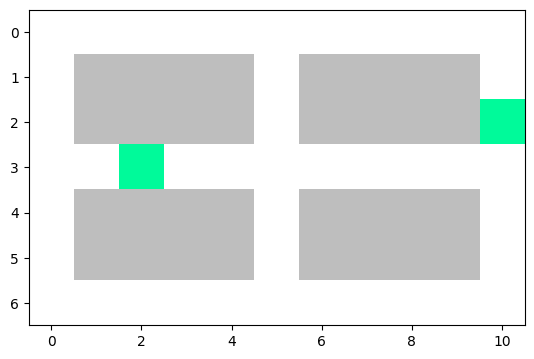

2024-06-18 14:47:00,263 - 20764 - __init__.py-__init__:518 - WARNING: Overriding of current TracerProvider is not allowed




> Entering new CrewAgentExecutor chain...


2024-06-18 14:47:01,960 - 20764 - __init__.py-__init__:518 - WARNING: Overriding of current TracerProvider is not allowed


Since my current coordinates are the same as my destination coordinates, I don't need to move anywhere.

Final Answer: Stay.

> Finished chain.


> Entering new CrewAgentExecutor chain...
Since my current location (2,7) is the same as my destination (2,7), I do not need to move at all.

Final Answer: Stay.

> Finished chain.


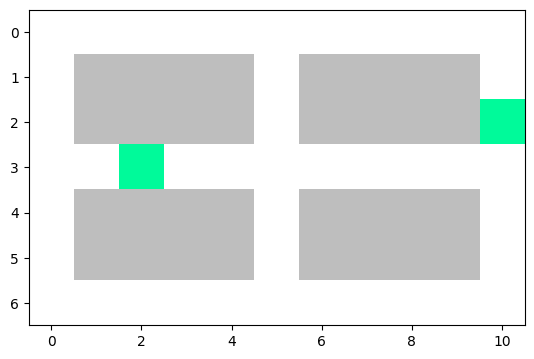

2024-06-18 14:47:04,612 - 20764 - __init__.py-__init__:518 - WARNING: Overriding of current TracerProvider is not allowed




> Entering new CrewAgentExecutor chain...


2024-06-18 14:47:06,015 - 20764 - __init__.py-__init__:518 - WARNING: Overriding of current TracerProvider is not allowed


Considering my current coordinates and the destination coordinates are the same, I have reached my goal. 

Final Answer: Stay

> Finished chain.


> Entering new CrewAgentExecutor chain...
Since my current coordinates (2,7) are the same as my destination (2,7), I have already reached my goal. Therefore, I do not need to move in any direction.

Final Answer: Stay

> Finished chain.


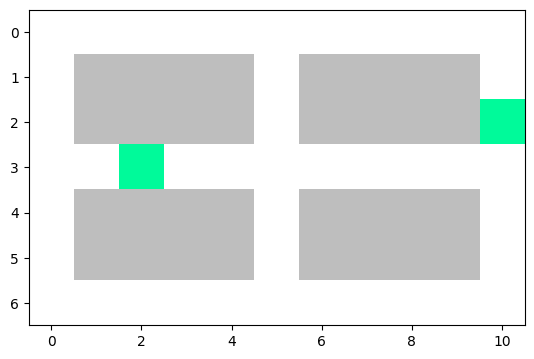

2024-06-18 14:47:09,051 - 20764 - __init__.py-__init__:518 - WARNING: Overriding of current TracerProvider is not allowed




> Entering new CrewAgentExecutor chain...


2024-06-18 14:47:10,367 - 20764 - __init__.py-__init__:518 - WARNING: Overriding of current TracerProvider is not allowed


Since my current coordinates are the same as my destination, I don't need to move.

Final Answer: Stay.

> Finished chain.


> Entering new CrewAgentExecutor chain...
Since I am already at my destination (2,7), there is no need to move in any direction.

Final Answer: Stay

> Finished chain.


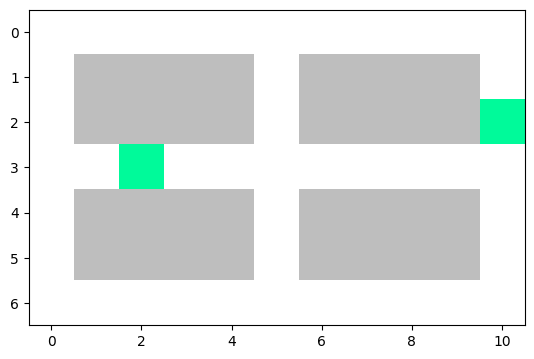

2024-06-18 14:47:12,492 - 20764 - __init__.py-__init__:518 - WARNING: Overriding of current TracerProvider is not allowed




> Entering new CrewAgentExecutor chain...


2024-06-18 14:47:14,650 - 20764 - __init__.py-__init__:518 - WARNING: Overriding of current TracerProvider is not allowed


Since my current coordinates (10,8) are the same as my destination (10,8), I have already reached my goal. There is no need for me to move in any direction.

Final Answer: Stay

> Finished chain.


> Entering new CrewAgentExecutor chain...
Since I'm already at my destination coordinates (2,7), there's no need for me to move. Therefore, my best move would be to stay.

Final Answer: Stay.

> Finished chain.


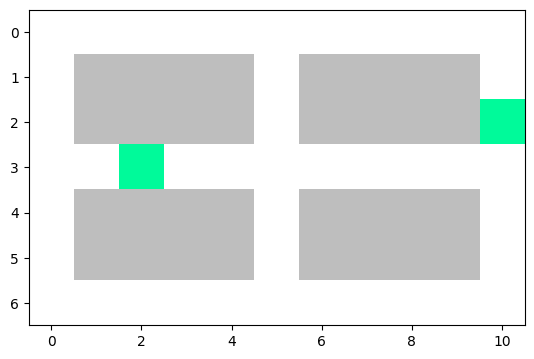

2024-06-18 14:47:17,693 - 20764 - __init__.py-__init__:518 - WARNING: Overriding of current TracerProvider is not allowed




> Entering new CrewAgentExecutor chain...


2024-06-18 14:47:19,087 - 20764 - __init__.py-__init__:518 - WARNING: Overriding of current TracerProvider is not allowed


Since my current coordinates and destination are the same, I have already reached my goal. 

Final Answer: Stay

> Finished chain.


> Entering new CrewAgentExecutor chain...
Since I am already at my destination coordinates (2,7), I don't need to move anywhere. 

Final Answer: Stay.

> Finished chain.


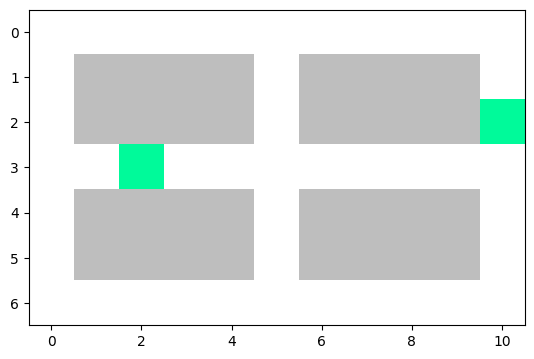

2024-06-18 14:47:21,432 - 20764 - __init__.py-__init__:518 - WARNING: Overriding of current TracerProvider is not allowed




> Entering new CrewAgentExecutor chain...


2024-06-18 14:47:23,252 - 20764 - __init__.py-__init__:518 - WARNING: Overriding of current TracerProvider is not allowed


Since my current coordinates (10,8) are the same as my destination (10,8), I have already reached my goal.

Final Answer: Stay.

> Finished chain.


> Entering new CrewAgentExecutor chain...
Since my current coordinates (2,7) are the same as my destination coordinates (2,7), I have reached my goal and therefore, I do not need to move.
Final Answer: Stay.

> Finished chain.


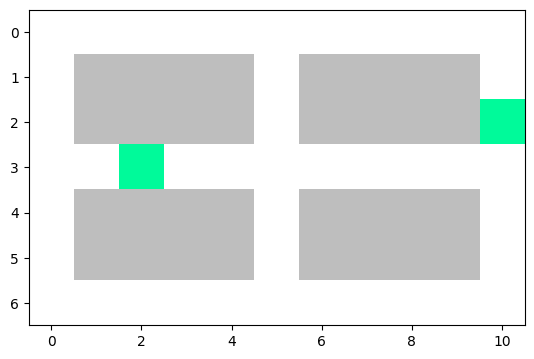

In [12]:
# 20 turn
for n in range(20):

  step = [0 for i in range(num_agents)]

  #각 에이전트들의 시야에 있는 자신과 다른 에이전트들
  FOV_agents = []
  for i in range(num_agents):
    if np.any(env.observe()[0][i][0][2:7, 2:7]):
      non_zero_elements = env.observe()[0][i][0][2:7, 2:7][env.observe()[0][i][0][2:7, 2:7] != 0].tolist()
      non_zero_elements = [element - 1 for element in non_zero_elements]
      non_zero_elements.append(i)
      FOV_agents.append(non_zero_elements)

  #알고리즘을 이용해 연결된 집합 찾기
  connected_sets = merge_sets(FOV_agents)

  #연결이 있는 모든 에이전트들
  deadlocked_agents = [item for sublist in connected_sets for item in sublist]

  for i in range(num_agents):

    #교착상태에 빠지지 않은 에이전트는 독립적으로 navigate
    if i not in deadlocked_agents:
      
      a_obs = env.observe()[0][i][1]
      x = env.observe()[1][i][1]
      y = map_width-env.observe()[1][i][0]
      x_finish = toy[2][i][1]
      y_finish = map_width-toy[2][i][0]

      if a_obs[4][3] == 0:
        west = """To your west lies a path."""
      else:
        west = """Your west is blocked by a wall."""

      if a_obs[4][5] == 0:
        east = """To your east lies a path."""
      else:
        east = """Your east is blocked by a wall."""

      if a_obs[5][4] == 0:
        south = """To your south lies a path."""
      else:
        south = """Your south is blocked by a wall."""

      if a_obs[3][4] == 0:
        north = """To your north lies a path."""
      else:
        north = """Your north is blocked by a wall."""

      if len(action_list[i]) == 0:
        last_action = """"""
      elif action_list[i][-1] in ['West', 'West.']:
        last_action = f"""You came from east."""
      elif action_list[i][-1] in ['East', 'East.']:
        last_action = f"""You came from west."""
      elif action_list[i][-1] in ['South', 'South.']:
        last_action = f"""You came from north."""
      elif action_list[i][-1] in ['North', 'North.']:
        last_action = f"""You came from south."""
      elif action_list[i][-1] in ['Stay', 'Stay.']:
        last_action = f"""You paused once for another agent or you reached your goal."""
      else:
        last_action = """"""

      navigation = tasks.path_finding(agents_set[i], x, y, x_finish, y_finish, east, west, north, south, last_action)

      crew = Crew(
        agents=[agents_set[i]],
        tasks=[navigation],
        verbose=0,
      )

      result = crew.kickoff()

      action_list[i].append(result)
    
      step[i] = directiondict[result]
  
  # 교착상태에 빠진 에이전트에 대해
  for connected_set in connected_sets:
    
    results = []

    for i in connected_set: # 여기서 i는 agent의 번호들
    
    #각각의 에이전트에 대해 원래 계획된 경로를 계산

      a_obs = env.observe()[0][i][1]
      x = env.observe()[1][i][1]
      y = map_width-env.observe()[1][i][0]
      x_finish = toy[2][i][1]
      y_finish = map_width-toy[2][i][0]

      if a_obs[4][3] == 0:
        west = """To your west lies a path."""
      else:
        west = """Your west is blocked by a wall."""

      if a_obs[4][5] == 0:
        east = """To your east lies a path."""
      else:
        east = """Your east is blocked by a wall."""

      if a_obs[5][4] == 0:
        south = """To your south lies a path."""
      else:
        south = """Your south is blocked by a wall."""

      if a_obs[3][4] == 0:
        north = """To your north lies a path."""
      else:
        north = """Your north is blocked by a wall."""

      if len(action_list[i]) == 0:
        last_action = """"""
      elif action_list[i][-1] in ['West', 'West.']:
        last_action = f"""You came from east."""
      elif action_list[i][-1] in ['East', 'East.']:
        last_action = f"""You came from west."""
      elif action_list[i][-1] in ['South', 'South.']:
        last_action = f"""You came from north."""
      elif action_list[i][-1] in ['North', 'North.']:
        last_action = f"""You came from south."""
      elif action_list[i][-1] in ['Stay', 'Stay.']:
        last_action = f"""You paused once for another agent or you reached your goal."""
      else:
        last_action = """"""

      navigation = tasks.path_finding(agents_set[i], x, y, x_finish, y_finish, east, west, north, south, last_action)

      crew = Crew(
        agents=[agents_set[i]],
        tasks=[navigation],
        verbose=0,
      )

      result = crew.kickoff()

      results.append(result)

    env_copy = copy.deepcopy(env)
    planned_step = [0 for _ in range(num_agents)]
    for idx, agent_idx in enumerate(connected_set):
      planned_step[agent_idx] = directiondict[results[idx]]
    if -0.5 in env_copy.step(planned_step)[1]:
      collision = True
    else:
      collision = False

    if not collision:
      for idx, agent_idx in enumerate(connected_set):
        action_list[agent_idx].append(results[idx])
        step[agent_idx] = directiondict[results[idx]]
# 충돌한다면 가장 큰 넘버의 에이전트가 우선권을 가지고, 나머지는 그를 피해가야 함 (이 부분을 좀더 정교화할 필요가 있음, 특히 3명 이상의 에이전트에 대한 경우. 일단 기본적으로는 얽힌 모든 에이전트가 가장 번호가 높은 에이전트에게서 도망가게.)
# 특히, 먼저 도착한 에이전트는 장애물이 되어 그 멈춘 에이전트를 발견한 다른 에이전트의 heuristic map이 업데이트되어야 함 (멈춘 에이전트로 인해 예상치 못한 deadend가 생김)
    else:
    # 먼저 prior agent는 원래대로 이동하게 함
      prior_agent_number = max(connected_set)
      prior_agent_idx = connected_set.index(prior_agent_number)
      action_list[prior_agent_number].append(results[prior_agent_idx])
      step[prior_agent_number] = directiondict[results[prior_agent_idx]]
      for i in connected_set:
        if i != prior_agent_number:
            a_obs = env.observe()[0][i][1]
            x = env.observe()[1][i][1]
            y = map_width-env.observe()[1][i][0]
            x_finish = toy[2][i][1]
            y_finish = map_width-toy[2][i][0]

            if a_obs[4][3] == 0:
                west = """To your west lies a path."""
            else:
                west = """Your west is blocked by a wall."""

            if a_obs[4][5] == 0:
                east = """To your east lies a path."""
            else:
                east = """Your east is blocked by a wall."""

            if a_obs[5][4] == 0:
                south = """To your south lies a path."""
            else:
                south = """Your south is blocked by a wall."""

            if a_obs[3][4] == 0:
                north = """To your north lies a path."""
            else:
                north = """Your north is blocked by a wall."""

            # prior agent의 direction 구하기
            agent_map = env.observe()[0][i][0][2:7, 2:7]
            center = (2, 2)
            max_position = np.unravel_index(np.argmax(agent_map), agent_map.shape)

            row_diff = center[0] - max_position[0]
            col_diff = center[1] - max_position[1]

            if row_diff > 0 and col_diff > 0:
                direction = "northwest"
            elif row_diff > 0 and col_diff == 0:
                direction = "north"
            elif row_diff > 0 and col_diff < 0:
                direction = "northeast"
            elif row_diff == 0 and col_diff > 0:
                direction = "west"
            elif row_diff == 0 and col_diff < 0:
                direction = "east"
            elif row_diff < 0 and col_diff > 0:
                direction = "southwest"
            elif row_diff < 0 and col_diff == 0:
                direction = "south"
            elif row_diff < 0 and col_diff < 0:
                direction = "southeast"
            else:
                direction = "center"

            give_way = tasks.give_way(agents_set[i], east, west, north, south, direction)

            crew = Crew(
                agents=[agents_set[i]],
                tasks=[give_way],
                verbose=0,
            )

            result = crew.kickoff()

            action_list[i] = []
    
            step[i] = directiondict[result]


  env.step(step)
  env.render()